In [1]:
# Dataset: Amazon Books Reviews
# Author: Mohamed Bekheet
# Source: Mohamed Bekheet. (2022). Amazon Books Reviews [Data set]. Kaggle. https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# This dataset contains 2 files
# The first file** reviews** file contain feedback about 3M user on 212404 unique books the data set is 
# part of the Amazon review Dataset it contains product reviews and metadata from Amazon, including 
# 142.8 million reviews spanning May 1996 - July 2014.
# Reviews Dataset Data Dictionary:
# -id:                  The Id of Book
# -Title:   	        Book Title
# -Price:               The price of Book
# -User_id:             Id of the user who rates the book
# -profileName:         Name of the user who rates the book
# -review/helpfulness:  helpfulness rating of the review, e.g. 2/3
# -review/score:        rating from 0 to 5 for the book
# -review/time:         time of given the review
# -review/summary:      the summary of a text review
# -review/text:         the full text of a review

# The second file Books Details file contains details information about 212404 unique books it file is built by using
# google books API to get details information about books it rated in the first file
# and this file contains

# Book Details Dataset Data Dictionary:
# Title:	        Book Title
# Descripe:	        Decription of book
# authors:	        Name of book authors
# image:	        Url for book cover
# previewLink:	    Link to access this book on google Books
# publisher:	    Name of the publisheer
# publishedDate:	The date of publish
# infoLink:	        Link to get more information about the book on google books
# categories:	    Genres of books
# ratingsCount:	    Averaging rating for book

# Both Datasets are linked through the unique tittle of the book.

In [2]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from dateutil.parser import parse
from datetime import datetime
# ------------  PREPROCESING -------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#-------------- TRANSFORMERS --------------
import transformers
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import pipeline
import evaluate
from evaluate import load
from transformers import Conversation
transformers.logging.set_verbosity_error()

/home/arnaldochm/Documents/BootCamp_DataScience/Final_Project/final_project_nlp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-02 22:39:53.899849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 22:39:53.901479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 22:39:53.939682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 22:39:53.940389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [3]:
#Loading the Datasets
df_rating_raw = pd.read_csv('../data/raw/Books_rating.csv')

df_rating_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [4]:
df_rating_raw[df_rating_raw['Title'] == 'West Side story']

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1814312,B000711OZC,West Side story,NaN,A3FV7U97W17PK,"M. Chaerani ""music sheet collector""",26/26,5.0,1145491200,Great transcription of the full score,If you're looking for a faithful translation f...
1814313,B000711OZC,West Side story,NaN,A14ES1GLFF6RZ9,"The Pianoman ""Producer/Arranger""",6/7,5.0,1189987200,West Side Vocal Score,If you want to play/arrange/orchestrate or sim...
1814314,B000711OZC,West Side story,NaN,APYTEBHJXFT18,Teen,4/5,4.0,1167177600,For the intermediate,The book is medium-it isn't an easy book you o...
1814315,B000711OZC,West Side story,NaN,A3H9EZYOVG81TW,Broadway Fan,1/1,5.0,1332374400,West Side Story,This book is perfect. We are rehearsing West S...
1814316,B000711OZC,West Side story,NaN,A1IWMVQGALYNVK,C. Morgan,3/4,5.0,1199145600,High Quality Printing,The piano and vocals are clearly printed which...
1814317,B000711OZC,West Side story,NaN,AZUS7ZIZWEJ0B,"Rebecca L. Gosselin ""Capegirl78""",0/0,5.0,1355702400,Fab!,this was perfect - I wanted to real versions o...
1814318,B000711OZC,West Side story,NaN,A1F2FPNK5VBJZ4,"W. Smith ""Future Tony Winner""",0/0,5.0,1264636800,A Composer/Orchestrator's Best Friend,My original intention was to buy this and use ...
1814319,B000711OZC,West Side story,NaN,A2DGD1PGXR5BZM,Olivertrst,0/1,3.0,1319241600,Disappointed -- Bent in shipping,I was disappointed when I received this book i...
1814320,B000711OZC,West Side story,NaN,A1GURUV4HPAWFU,Krista Cronin,2/9,5.0,955411200,West Side Story is Fabulous,"The music from West Side Story is captivating,..."


In [5]:
df_rating_raw.sample(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
219028,B00005VOED,A confederacy of dunces,NaN,A3URGLVPWJLBLV,Nathaniel Raley,3/7,5.0,1149206400,Offering a counterpoise In reply to the dissid...,"""What an egregious offense to taste and decenc..."
93002,B000KIT9U4,The Shelters Of Stone - The Earth's Children S...,NaN,A35C99W7OH3U5Y,BLS,0/0,1.0,1024963200,Shelters of Stone,"No story line, no plot, nothing new. Jean Auel..."
403247,B000PG8SOE,One Fish two fish red fish blue fish (Beginner...,NaN,NaN,NaN,3/3,4.0,890265600,It's a classic!,"If your child is a beginning reader, consider ..."
2393495,0941599639,Cooking with Coconut Flour: A Delicious Low-Ca...,11.43,A2HTBFD10ZDHGQ,Patti,0/0,5.0,1361404800,Excellent resource!,This book is FULL of useful recipes for coconu...
1564564,1555834574,"Boy in the Sand: Casey Donovan, All-American S...",NaN,A3UW3RWVYU9JQ3,"Wayne M. Malin ""Preppy""",0/0,5.0,1352332800,Fascinating if suspect,Biography of gay porn star Casey Donovan. He w...
2278655,0789470802,Eyewitness Travel Guide to Chicago,NaN,A13E0ARAXI6KJW,Ed Uyeshima,6/6,3.0,1197417600,Second City Given Secondary Treatment in the O...,"For the most part, Dorling Kindersley's Eyewit..."
614754,0895266180,The Coercive Utopians: Social Deception by Ame...,NaN,A1MJ4QOU18GJ2K,Bruce Ware,10/14,4.0,1057881600,&quot;Power players&quot;?,"At first glance, you might think this book is ..."
1988498,B000PGI7QI,Atlas Shrugged,NaN,NaN,NaN,5/6,5.0,931132800,BEST book I ever read,Twelve years after having read &quot;Atlas Shr...
966624,B00087JQ0K,Christmas Stories (Standard Literature Series),NaN,AQPVM5QUNJCAE,Judy,6/7,1.0,1260921600,Christmas Stories,This printing by General Books is unreadable. ...
2576755,080507788X,"Cousins and Strangers: America, Britain, and E...",NaN,AMFA6FJHTMU8U,Ralph Blumenau,2/2,5.0,1157155200,A civilized mind looks at the world.,From 1999 to 2004 Chris Patten was a member of...


In [6]:
#Load Books Data Dataset
df_data_raw = pd.read_csv('../data/raw/books_data.csv')

df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [7]:
df_data_raw.sample(10)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
178749,DR. SEUSS'S SLEEP BOOK,Catch a case of the yawns with Dr. Seuss in th...,['Dr. Seuss'],http://books.google.com/books/content?id=TrPxA...,http://books.google.com/books?id=TrPxAwAAQBAJ&...,RH Childrens Books,2013-10-22,https://play.google.com/store/books/details?id...,['Juvenile Fiction'],20.0
146760,THE TEMPTATION: EDGAR TOLSON AND THE GENESIS O...,"Why, beginning in the late 1960s, did expressi...",['Julia S. Ardery'],http://books.google.com/books/content?id=r39LC...,http://books.google.com/books?id=r39LCcqKnmgC&...,UNC Press Books,1998,http://books.google.com/books?id=r39LCcqKnmgC&...,['Art'],NaN
198808,The Literary Life and Other Curiosities: 2,NaN,['Robert Hendrickson'],http://books.google.com/books/content?id=Oa-WF...,http://books.google.com/books?id=Oa-WFXW7cJ4C&...,Penguin Group,1982,http://books.google.com/books?id=Oa-WFXW7cJ4C&...,['Authorship'],NaN
205631,Insight Guide South America (Insight Guides So...,"With a wealth of history and ancient ruins, di...",['Insight Guides'],http://books.google.com/books/content?id=HRRDD...,http://books.google.com/books?id=HRRDDwAAQBAJ&...,Rough Guides UK,2017-12-01,https://play.google.com/store/books/details?id...,['Travel'],NaN
37866,Oil and Arab regional development (Praeger spe...,The book traces the history of various attempt...,['Kamal S. Sayegh'],http://books.google.com/books/content?id=G5DtA...,http://books.google.com/books?id=G5DtAAAAMAAJ&...,Praeger,1978,http://books.google.com/books?id=G5DtAAAAMAAJ&...,['Business & Economics'],NaN
178242,Compulsive Behavior: A Novel of Suspense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91645,The Complete Book of Boxing for Fighters and F...,The former world welterweight champion discuss...,"['Curtis Cokes', 'Hugh Kayser']",http://books.google.com/books/content?id=l6LsG...,http://books.google.com/books?id=l6LsGAAACAAJ&...,Etc Publications,1980-01-01,http://books.google.com/books?id=l6LsGAAACAAJ&...,['Sports & Recreation'],NaN
140660,Symphonic Theology: The Validity of Multiple P...,The truth of God is rich and multifaceted. Tho...,['Vern S. Poythress'],http://books.google.com/books/content?id=mDQGA...,http://books.google.com/books?id=mDQGAAAACAAJ&...,P & R Publishing,2001-08-01,http://books.google.com/books?id=mDQGAAAACAAJ&...,['Religion'],1.0
18495,Sir MacHinery,A mechanical robot with a computer brain is he...,['Tom McGowen'],NaN,http://books.google.nl/books?id=6UTXGAAACAAJ&d...,Follett,1970-01-01,http://books.google.nl/books?id=6UTXGAAACAAJ&d...,['Fantasy'],1.0
24762,The business of trading in stocks,2013 Reprint of 1927 Edition. Full facsimile o...,['John Durand'],http://books.google.com/books/content?id=TQnQn...,http://books.google.com/books?id=TQnQngEACAAJ&...,NaN,2013-08,http://books.google.com/books?id=TQnQngEACAAJ&...,['Literary Collections'],NaN


In [8]:
#Revisar Valores Nulos
df_rating_raw.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

In [9]:
df_data_raw.isna().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [10]:
#Innecesary Columns are removed
# df_rating: 
#   - Price: Almost 84% of the entries are null. 
#   - profileName: User_id provides same information.
#   - Id: Innecesary column.
#   - review/summary: Unncesary column for current analysis. Many summaries used are the same Book Title.  
# df_data:
#   - image, previewLink, infoLink: Not useful information.
#   - ratingsCount: Information from Google API. Not useful for the analysis.
#   - description: Non necesary information for Analysis

df_rating_processed = df_rating_raw.drop(['Id','profileName','Price','review/summary'], axis=1).copy()
df_data_processed = df_data_raw.drop(['image','previewLink','infoLink','ratingsCount','description'], axis=1).copy()

In [11]:
df_rating_processed.sample(10)

,Title,User_id,review/helpfulness,review/score,review/time,review/text
2492091,The Hobbit,A3JOR9G95DV4U8,1/1,5.0,1356220800,"I will admit, I was supposed to read this book..."
2510495,GINGER: MY STORY (INSCRIBED),A2P92X8EOC3OVH,0/1,2.0,1337040000,"Her story is too much child hood so far, I hav..."
646179,"Whistling Season, a Novel",A1YYXNPKN661SW,0/0,5.0,1187222400,I chose this book as my take-along on vacation...
284406,Q is for Quarry: A Kinsey Millhone Mystery,ANQZJTOZ0B6L4,7/8,4.0,1035676800,"This one isnt quite there as past works, it is..."
2911457,Second Foundation [Paperback],A1D1AE3E4G9BTY,0/2,3.0,1086048000,"I enjoyed the Foundation series very much, and..."
800823,The Norton Anthology of Literature by Women: T...,A1Q34A2SBLHG4V,1/1,4.0,1227312000,"Had to take a diversity course in college, and..."
1532395,"Journal of the Federal Convention, Kept by Jam...",AMNZGOYTLDVEO,3/4,5.0,1280188800,I found the problem in the index and the few t...
964554,The English Patient,A2CVVCODXDVJO6,1/2,5.0,962064000,Desipte Minghella's focus on the romance of th...
2018427,WORLD OF ANIMALS (Tell Me About),A2I9TB1ZUPFA8T,0/1,5.0,1329868800,The World of Animals- Fascinating Facts About ...
887121,Perennials All Season : Planning and Planting ...,A4JT4D1DONUK5,19/19,5.0,1063584000,I have alot of gardening books and this one st...


In [12]:
df_rating_processed = df_rating_processed.rename(columns={'Title':'title', 
                                                        'User_id':'user_id',
                                                        'review/helpfulness': 'helpfulness',
                                                        'review/score': 'review',
                                                        'review/time': 'review_time',
                                                        'review/text': 'text'
                                                        })
df_data_processed = df_data_processed.rename(columns={'Title':'title', 
                                                        'publishedDate':'published_date'
                                                        })

In [13]:
df_rating_processed.isna().sum()

title             208
user_id        561787
helpfulness         0
review              0
review_time         0
text                8
dtype: int64

In [14]:
df_data_processed.isna().sum()

title                 1
authors           31413
publisher         75886
published_date    25305
categories        41199
dtype: int64

In [15]:
#CLEAN THE DATASETS

In [16]:
#As both datasets are going to be merged by Title, Rows with Null Title are removed.
df_rating_processed = df_rating_processed.dropna(subset=['title', 'text'], how='any')

df_data_processed = df_data_processed.dropna(subset=['title'])

#Drop rows where everything except title is null
df_data_processed = df_data_processed.dropna(subset=['authors', 'publisher', 'published_date', 'categories'], how='all')

In [17]:
df_data_processed.sample(5)

,title,authors,publisher,published_date,categories
212175,Kilimanjaro: Sons of Kilimanjaro,['Macon Dunnagan'],NaN,2009-10,['Fiction']
153513,The third generation (A Signet book),['Chester B. Himes'],NaN,1964,['African Americans']
161760,The Everything Speaking Mandarin Chinese Book,['J. F. Grasso'],Adams Media,2006-12-14,['Foreign Language Study']
78778,Concealed Judgement,['Briggs Depew'],NaN,2016,NaN
168333,CLEP Natural Sciences ( College Level Examinat...,NaN,NaN,2010*,['College-level examinations']


In [18]:
# Found 143 published_date entries with the format YYYY*
# Found 76 published_date entries with the format YYY?
# Found 52 published_date entries with the format YY??

def convert_to_year(date_in):    
    try:    
        patern_1 = r'\d\d\d\?'
        patern_2 = r'\d\d\?\?'

        #Some dates only contain the Year with the format YYYY*. For those cases, the symbol * is removed.
        date = date_in.replace('*', '')

        #Other cases contains an ? symbol instead of a number on the Year. YYY? or YY??
        #For this specific case, the rounded mean from 0 to 9 is used: 5
        if re.match(patern_1, date):
            date = date.replace('?', '5')

        if re.match(patern_2, date):
            return None

        date = parse(date)
        
        return date.strftime("%Y")
    except:        
        return None

In [19]:
#Use only the year for published_date
df_data_processed['published_year'] = df_data_processed['published_date'].apply(lambda x: convert_to_year(x) if pd.notna(x) else x)

df_data_processed['published_year'] = df_data_processed['published_year'].fillna('0')

df_data_processed['published_year'] = df_data_processed['published_year'].astype('int32')

#Drop published_date column 
df_data_processed = df_data_processed.drop(['published_date'], axis=1)

In [20]:
mean_published_year = int(df_data_processed['published_year'].mean())
mean_published_year

1981

In [21]:
df_data_processed['published_year'] = df_data_processed['published_year'].apply(lambda x: mean_published_year if x==0 else x)
df_data_processed.sample(10)

,title,authors,publisher,categories,published_year
212156,Clinical Phonetics (2nd Edition),"['Lawrence D. Shriberg', 'Raymond D. Kent', 'J...",NaN,['English language'],2018
103817,Parallax: The Race to Measure the Cosmos,['Alan W. Hirshfeld'],Courier Corporation,['Science'],2013
71523,"Psychiatric Drugs Explained, 4e",['DAVID. HEALY'],Elsevier,['Medical'],2022
4231,Amphoras and the ancient wine trade (Excavatio...,['Virginia Grace'],ASCSA,['History'],1979
30154,A Woman Named Damaris (Women of the West #4),['Janette Oke'],Baker Books,['Fiction'],2007
68685,"The Active Society, a Theory of Societal and P...",['Amitai Etzioni'],NaN,['Political sociology'],1968
24260,My Christmas ABC Book,['Florence Johnson'],Golden Books,['Juvenile Fiction'],2013
115149,"Patisserie: An Encyclopedia of Cakes, Pastries...",['Aaron Maree'],Harpercollins,['Baking'],1994
188456,Ireland Ever: The Photographs of Jill Freedman,"['Jill Freedman', 'Frank McCourt', 'Malachy Mc...",Harry N Abrams Incorporated,['Photography'],2004
185255,Renoir (An Abrams art book),"['Auguste Renoir', 'Milton S. Fox']",NaN,NaN,1952


In [22]:
def custom_string_to_list(s):
    if isinstance(s, str):
        return [item.strip(" '[]") for item in s.split(',')]
    else:
        return s

In [23]:
#Updating the Authors to a list.
#Updating Categories to list
df_data_processed['authors'] = df_data_processed['authors'].apply(custom_string_to_list)
df_data_processed['categories'] = df_data_processed['categories'].apply(custom_string_to_list)

In [24]:
df_data_processed.sample(10, random_state=20)

,title,authors,publisher,categories,published_year
134060,Galois theory;: Lectures delivered at the Univ...,[Emil Artin],Courier Corporation,[Mathematics],2012
2306,The Sunday Tertulia: A Novel,[Lori Marie Carlson],Harper Collins,[Fiction],2009
49270,Suddenly They're 13,[David and Claudia Arp],Zondervan,[Religion],2010
115253,BEYOND MONSTERS AND CLOWNS. THE COMBAT SS. : D...,[Karl H. Theile],University Press of Amer,[History],1997
120696,Virginians at home: Family life in the eightee...,[Edmund Sears Morgan],Colonial Williamsburg Foundation,[History],1952
194758,Food Choice and Obesity in Black America: Crea...,[Eric J. Bailey],Greenwood Publishing Group,[African Americans],2006
10043,Lake Geneva in Vintage Postcards (WI) (Postcar...,"[Carolyn Hope Smeltzer, Martha Kiefer Cucco]",Arcadia Publishing,[History],2005
16651,"Where Are You Going, Manyoni?",[Catherine Stock],Harpercollins Childrens Books,[Juvenile Fiction],1993
61146,Twenty One Days to a Trained Dog,"[Dick Maller, Jeffrey Feinman]",Simon and Schuster,[Pets],1979
55622,"The German campaigns in the Balkans (spring, 1...",[George E. Blau],NaN,"[World War, 1939-1945]",1986


In [25]:
df_rating_processed.sample(5)

,title,user_id,helpfulness,review,review_time,text
377015,What to Do When You Can't Get Pregnant: The Co...,A29381YVBY63P5,0/0,5.0,1325030400,I got Plan to Get Pregnant first. That was a g...
1750480,My Life So Far,A2JCTAK4UWGRYL,2/11,3.0,1122508800,I enjoyed the book on a general basis. I have ...
1043543,Jim Cramer's Real Money: Sane Investing in an ...,A2YSXEDOU4UIEH,15/25,1.0,1136851200,I read this book twice in as many days to see ...
864887,"Tales of Passion, Tales of Woe",A1THZGKQFRMLYW,0/0,5.0,1263254400,I am so addicted to this series and cannot wai...
1408997,Messages to Young People,A380JHXP6H66T7,4/5,5.0,1117584000,This book has blessed me beyond measure. It gi...


In [26]:
# CLEANING DATA FOR REVIEWS DATASET
df_rating_processed['review_year'] = df_rating_processed['review_time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

df_rating_processed = df_rating_processed.drop(['review_time'], axis=1)

In [27]:
df_rating_processed.sample(10)

,title,user_id,helpfulness,review,text,review_year
2724713,It,NaN,0/0,5.0,I jsut wanted to say that this book was the fi...,1999
2343200,"Ulysses,",NaN,12/12,5.0,This is one of the classic texts of experiment...,2001
901306,The Sword in the Stone,A1D2C0WDCSHUWZ,34/38,5.0,"""Sword in the Stone"" is the must-read book of ...",2002
251368,Black Wind,A113FIOV66Q881,1/1,5.0,I read this book several years ago and the ima...,2007
1046075,"Animal Farm (Signet Classics, CT304)",A1E8TZ54U3273R,0/0,5.0,"""All animals are equal, but some are more equa...",2003
256413,The Bear and the Dragon,A2LX8HNMG9J0IX,3/19,5.0,unlike some people i read the whole book to kn...,2002
2478663,Bobby Fischer Goes to War : How the Soviets Lo...,A257E4U95O3CHP,6/8,4.0,This book is coming out at the right time. Wit...,2005
2292325,"Your Right to Child Custody, Visitation and Su...",AXC8REHKMXK0D,0/0,1.0,Just like a lawyer. Just the facts. No heart o...,2009
864269,The Roman way,A27Q9NX3M3GN63,3/7,5.0,No one wrote about ancient history as well as ...,2002
1364499,The Red Tent (Bestselling Backlist),A25ZIJGHJCPT6I,4/4,4.0,I have not yet quite finished &quot;The Red Te...,2003


In [28]:
#Changing helpfulness to a porcentual value
def get_helpfulness_as_porcentual_value_0(x):
    if  x == '0/0':
        return 0
    elif x.split('/')[0] == '0':
        return 0
    else:
        dividend = int(x.split('/')[0])
        divisor = int(x.split('/')[1])
        return dividend/divisor
    
def get_helpfulness_as_porcentual_value_1(x):
    if  x == '0/0':
        return 1
    elif x.split('/')[0] == '0':
        return 0
    else:
        dividend = int(x.split('/')[0])
        divisor = int(x.split('/')[1])
        return dividend/divisor

In [29]:
df_rating_processed['helpfulness_0'] = df_rating_processed['helpfulness'].apply(lambda x: get_helpfulness_as_porcentual_value_0(x))
df_rating_processed['helpfulness_1'] = df_rating_processed['helpfulness'].apply(lambda x: get_helpfulness_as_porcentual_value_1(x))
df_rating_processed = df_rating_processed.drop(['helpfulness'], axis=1)

In [30]:
df_rating_processed.sample(10)

,title,user_id,review,text,review_year,helpfulness_0,helpfulness_1
427947,The Scofield Study Bible III: New American Sta...,A32WIWE5OU83PE,5.0,"I ordered this for my son, and it was just wha...",2006,0.400000,0.400000
2971443,Silver Pennies,AWVWX5F3YEJKZ,5.0,This book was given to me over 30 years ago by...,1969,1.000000,1.000000
1575550,Larousse Concise Spanish-English English-Spani...,AQJRKHAWU1TCU,5.0,"This dictionary, which our teacher recommended...",2008,1.000000,1.000000
2948934,The Principal as Professional Development Leader,A1P9P6194SI7TI,5.0,This is a great book and provides some great d...,2011,0.000000,1.000000
296244,"Goddess of the Rose (Goddess Summoning, Book 4)",A1Y7WC48YRLZ8Z,4.0,This is the first PC Cast novel I've read. I e...,2006,0.000000,1.000000
452983,Goodnight Moon,AVUQF8Z7YE601,5.0,I love all of the Margaret Wise Brown books. A...,2007,0.000000,1.000000
2321964,When Difficult Relatives Happen to Good People,A1UD2HMNPIU7A2,5.0,This is an intuitive and useful book! Makes yo...,2013,0.000000,1.000000
2935397,It's Time to Call 911: What to Do in an Emergency,A3HDFAR85E57F6,5.0,In my opinion every child should have this boo...,2007,0.000000,1.000000
1989423,Atlas Shrugged,A3TLEBYBQ17XI,4.0,"Despite my general libertarian readings, I had...",2010,0.666667,0.666667
2360746,The Westing Game,NaN,4.0,I thought this book was really good. I think t...,2002,1.000000,1.000000


In [31]:
#Merge The Two Datasets.
df_all_data_processed = pd.merge(df_rating_processed, df_data_processed, on='title', how='inner')
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666314 entries, 0 to 2666313
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   title           object 
 1   user_id         object 
 2   review          float64
 3   text            object 
 4   review_year     int64  
 5   helpfulness_0   float64
 6   helpfulness_1   float64
 7   authors         object 
 8   publisher       object 
 9   categories      object 
 10  published_year  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 223.8+ MB


In [32]:
df_all_data_processed.sample(10)

,title,user_id,review,text,review_year,helpfulness_0,helpfulness_1,authors,publisher,categories,published_year
2435122,Five Lessons The Modern Fundamentals of Golf,AA40LWYO60VAQ,5.0,When published this book was regarded as the f...,2011,0.000000,1.000000,[Ben Hogan],Simon and Schuster,[Sports & Recreation],1985
1699959,"Star Trek, New Frontier: Books 1-4",A8JLRDLBCXX9R,5.0,I have read star trek novels for several years...,2012,0.000000,1.000000,[Peter David],Pocket Books/Star Trek,[Fiction],1997
1852325,Let Freedom Ring: Winning the War of Liberty o...,ARDC711FW68Y6,1.0,Sean Hannity seems to have a strong distaste f...,2012,0.666667,0.666667,[Sean Hannity],Zondervan,[Political Science],2009
70058,Mere Christianity,A34G318V8FNX8I,1.0,A friend recommended this book as something th...,2007,0.386364,0.386364,[C. S. Lewis],Harper Collins,[Religion],2009
391326,The Great Gatsby,NaN,2.0,"Truly, I know this is a American novel. This b...",1998,0.000000,1.000000,[F. Scott Fitzgerald],Pan Macmillan,[Fiction],2016
2061045,Heart of Darkness (Everyman Classics),A393EJD130USD6,5.0,"Conrad's Heart of Darkness, while being a shor...",2001,1.000000,1.000000,[Joseph Conrad],Everyman Chess,[Africa],1993
2647748,The Hobbit or There and Back Again,NaN,5.0,The Hobbit is about an unadventerous hobbit na...,2002,0.000000,0.000000,[J. R. R. Tolkien],Mariner Books,[Juvenile Fiction],2012
192034,Perfect for the Beach (Dean Brothers),A3QFDDODG2X2HL,4.0,"These stories entertained, satisfied and kept ...",2013,0.000000,1.000000,"[Janelle Denison, Erin McCarthy, Kayla Perrin,...",Kensington Books,[Fiction],2004
497255,Persuasion,A2ZP67U9WMYT3F,1.0,HUGE APOLOGIES TO JANE AUSTEN AND THIS WONDERF...,2013,0.000000,1.000000,[Jane Austen],"Little, Brown,",NaN,1899
888336,Tarnished Gold: The Record Industry Revisited,NaN,5.0,V.C. Andrews is the best of the best. In this ...,1997,0.000000,1.000000,[R. Serge Denisoff],Transaction Publishers,[Language Arts & Disciplines],1986


## Dataset Reduction/Sampling

Sample Size Calculation formula from Survey Monkey (https://www.surveymonkey.com/mp/sample-size-calculator/) is used to calculate a extract a ramdom sample of the dataset.
In order to reduce the dataset size and apply NLP to the text column.

For the given formula: 

   $$ sample size =  \frac{\frac{z^2xp(1-p)}{e^2}}{1 + \frac{z^2xp(1-p)}{e^2N}} $$

with:
- N = population size 
- e = Margin of error (percentage in decimal form) 
- z = z-score
- p = sample proportion


| Desired confidence level	| z-score |
|--------------------------|---------|
|            80%           |   1.28  |
|            85%	         |   1.44  |
|            90%	         |   1.65  |
|            95%	         |   1.96  |
|            99%	         |   2.58  |


Setting N = 2 666 313, e = 99% and z = 2.58

sample size = 578995. 

A sample of **578 995** entries will be extracted from the Dataset to be processed and to train and test the model.

In [33]:
N = df_all_data_processed.shape[0] - 1
e = 0.0015 #Margin of error = 0.15%
z = 2.58 # Desired confidence level = 99%, so z-score = 2.58
p = 0.5 #Used 0.5 as a conservative approach. It will give the largest sample size

sample_size = ( ((z*z)*p*(1-p))/(e*e) )/(1 + ((z*z)*p*(1-p))/(e*e*N) )

sample_size = round(sample_size)

print(f'Sample size is: {sample_size}')

Sample size is: 578995


In [34]:
#Extract the sample of 578995 entries from the dataset.
df_all_data_filtered_processed = df_all_data_processed.sample(n=sample_size, random_state=2125)

In [35]:
df_all_data_filtered_processed.reset_index(drop=True, inplace=True)
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578995 entries, 0 to 578994
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           578995 non-null  object 
 1   user_id         470719 non-null  object 
 2   review          578995 non-null  float64
 3   text            578995 non-null  object 
 4   review_year     578995 non-null  int64  
 5   helpfulness_0   578995 non-null  float64
 6   helpfulness_1   578995 non-null  float64
 7   authors         566598 non-null  object 
 8   publisher       481622 non-null  object 
 9   categories      531722 non-null  object 
 10  published_year  578995 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 48.6+ MB


In [36]:
df_all_data_filtered_processed['review'].value_counts()

review
5.0    349011
4.0    113195
3.0     48855
1.0     38541
2.0     29393
Name: count, dtype: int64

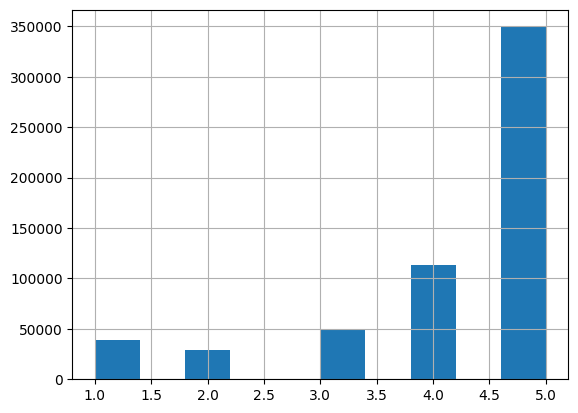

In [37]:
df_all_data_filtered_processed['review'].hist()
plt.show()
#Add axes.

In [38]:
df_all_data_filtered_processed.isna().sum()

title                  0
user_id           108276
review                 0
text                   0
review_year            0
helpfulness_0          0
helpfulness_1          0
authors            12397
publisher          97373
categories         47273
published_year         0
dtype: int64

In [39]:
df_all_data_filtered_processed.sample(10)

,title,user_id,review,text,review_year,helpfulness_0,helpfulness_1,authors,publisher,categories,published_year
164538,Four Weddings and a Funeral (Penguin Longman R...,NaN,5.0,A video you want to watch from time to time. I...,1999,1.000000,1.000000,"[Richard Curtis, Cherry Gilchrist]",Longman,[Foreign Language Study],2008
139856,Once an Eagle,A37YQDXR2U5AG3,5.0,Dvd movie was as promised. Very satisfied. Tha...,2012,0.000000,0.000000,[Anton Myrer],Harper Collins,[Fiction],2013
152450,Born in Fire: The Born In Trilogy #1 (CONCANNO...,A1LET68AV7TVDC,4.0,Born in Fire begins a wonderful trilogy with r...,2013,0.000000,1.000000,[Nora Roberts],Penguin,[Fiction],2013
108068,"The Legend of Huma: Heroes, Volume One",A9HAHXQKVM8SU,5.0,Richard A Knaak is one of the greatest authors...,1998,0.000000,1.000000,[Richard Knaak],Wizards of the Coast,[Fiction],2012
247037,It's All About Baby,A3BRLC9TZFF8D4,4.0,I loved this book.... very cute. I will be ord...,2004,1.000000,1.000000,[Nancy M. Hill],Leisure Arts,[Crafts & Hobbies],2004
489593,Little Women,A2TWWG5DZUQJBM,1.0,I agree with the reviewer below me 100%. This ...,2010,1.000000,1.000000,[Louisa May Alcott],Lindhardt og Ringhof,[Fiction],2018
244469,GUN KETCH (ALAN LEWRIE),A10QR6VFRA1KT,3.0,I began reading the Alan Lewrie series hoping ...,2010,0.750000,0.750000,[Dewey Lambdin],Canelo,[Fiction],2018
11559,King of the Sunset Strip: Hangin' with Mickey ...,A2BTDPPU8F4BNS,5.0,Whether everything's on the level here or not ...,2006,0.818182,0.818182,"[Steve Stevens, Craig Lockwood]",Cumberland House Publishing,[True Crime],2006
540494,The Book of Mormon Another Testament of Jesus ...,A1Y2J9FO9ABTAX,5.0,I'm amazed at some of the reviews here. I don'...,2004,0.617021,0.617021,[Joseph Smith (Jr.)],NaN,NaN,1954
133599,The Green Brain,ACEHBIYFYZ39O,1.0,"When I choose to read a book, I do so for one ...",2004,0.368421,0.368421,[Frank Herbert],NaN,[Insect pests],1969


In [40]:
df_all_data_filtered_processed = df_all_data_filtered_processed.drop_duplicates(subset=['title','user_id', 'review', 'text'])
df_all_data_filtered_processed.reset_index(drop=True, inplace=True)
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552641 entries, 0 to 552640
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           552641 non-null  object 
 1   user_id         449141 non-null  object 
 2   review          552641 non-null  float64
 3   text            552641 non-null  object 
 4   review_year     552641 non-null  int64  
 5   helpfulness_0   552641 non-null  float64
 6   helpfulness_1   552641 non-null  float64
 7   authors         540414 non-null  object 
 8   publisher       458732 non-null  object 
 9   categories      510313 non-null  object 
 10  published_year  552641 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 46.4+ MB


In [41]:
df_all_data_filtered_processed.sample(10)

,title,user_id,review,text,review_year,helpfulness_0,helpfulness_1,authors,publisher,categories,published_year
159747,"Chainfire: Chainfire Trilogy, Part 1 (Sword of...",A3Q7RGFVMW02Z,3.0,I'm not sure why I'm still reading SoT especia...,2005,0.571429,0.571429,[Terry Goodkind],Macmillan,[Fiction],2005
438823,The Once and Future King,A3T3QCIO8QOA81,3.0,The Once and Future King is a book with 4 diff...,2000,0.666667,0.666667,[T.H. White],Singel Uitgeverijen,[Fiction],2019
237988,Direct From Dell,A313H6238N589,3.0,Michael Dell sure isn't an exciting writer. Hi...,2004,1.000000,1.000000,"[Michael Dell, Catherine Fredman]",Harper Collins,[Business & Economics],2010
107560,Original Innocence,A3H7ZYF87GU96J,5.0,This book is ONE TO HAVE and the CEREMONY is a...,2001,0.666667,0.666667,"[Charles L. Moore, Charles L. Moore Jd Stb]",Booklocker.Com Incorporated,"[Body, Mind & Spirit]",2006
417144,The Hollow (Winterbrook Edition),A1S1JC7LTBZAH2,4.0,Most Christie fans think that her books from t...,2008,1.000000,1.000000,[Agatha Christie],Putnam Publishing Group,[Fiction],1946
285967,Pride & Prejudice (New Windmill),A2Y3Y55373HX9Y,5.0,the reason i have to tell you i liked it was b...,2012,0.000000,1.000000,[Ibi Zoboi],HarperCollins,[Young Adult Fiction],2018
541922,Midnight's children,A1WEOT1GQTCD8Z,3.0,While Rushdie is the author of Midnight's Chil...,2000,0.666667,0.666667,[Salman Rushdie],Vintage Canada,[Fiction],2010
231714,A Journey to the Center of the Earth,NaN,5.0,The Great Illustrated classics are great (no p...,2000,0.833333,0.833333,[Jules Verne],Sterling Publishing Company,[Fiction],2007
101557,Confessions of an Economic Hitman,AMZFJMQ8ZJF52,5.0,"Sad, but true. All American citizens should re...",2007,0.333333,0.333333,[John Perkins],Berrett-Koehler Publishers,[Biography & Autobiography],2016
539044,Harry Potter and the Chamber of Secrets,A37IBR8ILBNAJ,5.0,Herein we learn more about how the intertwinin...,2000,0.500000,0.500000,[J. K. Rowling],Raincoast Books,[Juvenile Fiction],1999


# Final Preprocesing from EDA Findings

## Helpfulness Outliers

During the EDA, it was discovered two entries Outliers for helpfulness column with helpfulness = 2

In [42]:
df_all_data_filtered_processed['helpfulness_0'].describe().T

count    552641.000000
mean          0.495408
std           0.430890
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           2.000000
Name: helpfulness_0, dtype: float64

In [43]:
# During the EDA, it was discovered a single Outlier for helpfulness column
df_all_data_filtered_processed['helpfulness_1'].describe().T

count    552641.000000
mean          0.788390
std           0.320185
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           2.000000
Name: helpfulness_1, dtype: float64

In [44]:
df_all_data_filtered_processed.shape

(552641, 11)

In [45]:
df_all_data_filtered_processed = df_all_data_filtered_processed.drop(df_all_data_filtered_processed[df_all_data_filtered_processed['helpfulness_0'] == 2].index)
df_all_data_filtered_processed[df_all_data_filtered_processed['helpfulness_0'] == 2]['helpfulness_0'].value_counts()

Series([], Name: count, dtype: int64)

In [46]:
df_all_data_filtered_processed.reset_index(drop=True, inplace=True)

In [47]:
df_all_data_filtered_processed.shape

(552639, 11)

In [48]:
df_all_data_filtered_processed['helpfulness_1'].describe().T

count    552639.000000
mean          0.788386
std           0.320177
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: helpfulness_1, dtype: float64

In [49]:
df_all_data_filtered_processed['helpfulness_0'].describe().T

count    552639.000000
mean          0.495402
std           0.430882
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: helpfulness_0, dtype: float64

## Authors Column

### Authors Names Standarization

During the Exploratory Data Analysis it was discovered that some authors are reviewed under diferent formats of their names. Based on this, the Dataset is simplified to contain only one name format.

In [50]:
#The examples are:
author_mapping = {
    'John Ronald Reuel Tolkien':'J. R. R. Tolkien',
    'J. R. R. Tolkien':'J. R. R. Tolkien',
    'J.R.R. Tolkien':'J. R. R. Tolkien',
    'Joseph Smith':'Joseph Smith',
    'Joseph Smith (Jr.)':'Joseph Smith',
    'Jr.':'Joseph Smith',
    'Gabriel Garcia Marquez':'Gabriel Garcia Marquez',
    'Gabriel García Márquez':'Gabriel Garcia Marquez',
    'Charlotte Brontë':'Charlotte Brontë',
    'Charlotte Bronte':'Charlotte Brontë',
    'Emily Brontë':'Emily Brontë',
    'Emily Bronte':'Emily Brontë',
    'Joseph Smith':'Joseph Smith',
    'Joseph Smith (Jr.)':'Joseph Smith',
    'Jr.':'Joseph Smith'
    }


In [51]:
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552639 entries, 0 to 552638
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           552639 non-null  object 
 1   user_id         449139 non-null  object 
 2   review          552639 non-null  float64
 3   text            552639 non-null  object 
 4   review_year     552639 non-null  int64  
 5   helpfulness_0   552639 non-null  float64
 6   helpfulness_1   552639 non-null  float64
 7   authors         540412 non-null  object 
 8   publisher       458730 non-null  object 
 9   categories      510311 non-null  object 
 10  published_year  552639 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 46.4+ MB


In [52]:
def standardize_authors(authors):
    if isinstance(authors, list):
        return [author_mapping.get(author, author) for author in authors]
    else:
        return authors  # Return the original value if it's not a list

In [53]:
df_all_data_filtered_processed['authors'] = df_all_data_filtered_processed['authors'].apply(standardize_authors)

### Updating the Authors Feature to Categorical, and applying Pareto Principe to reduce the quantity of authors.

In [54]:
author_counts = df_all_data_filtered_processed['authors'].explode().value_counts()
author_counts

authors
J. R. R. Tolkien       10036
Jane Austen             4525
Charles Dickens         3863
John Steinbeck          3343
Harper Lee              3021
                       ...  
John Janaro                1
Sarah C. Rich              1
Laurence SHAMES            1
Darrol Stinton             1
Frederic H. Martini        1
Name: count, Length: 89612, dtype: int64

In [55]:
sorted_author_counts = author_counts.sort_values(ascending=False)
sorted_author_counts

authors
J. R. R. Tolkien                 10036
Jane Austen                       4525
Charles Dickens                   3863
John Steinbeck                    3343
Harper Lee                        3021
                                 ...  
Frederick Winthrop Hutchinson        1
Carolyn G. Smith-Marker              1
Vena Angier                          1
Colin Kapp                           1
Frederic H. Martini                  1
Name: count, Length: 89612, dtype: int64

In [56]:
pareto_threshold = int(0.2 * len(sorted_author_counts))
pareto_threshold

17922

In [57]:
top_authors = sorted_author_counts.iloc[:pareto_threshold].index
top_authors

Index(['J. R. R. Tolkien', 'Jane Austen', 'Charles Dickens', 'John Steinbeck',
       'Harper Lee', 'Charlotte Brontë', 'Emily Brontë', 'Lewis Carroll',
       'Kurt Vonnegut', 'J. K. Rowling',
       ...
       'Tourbillon International', 'Eric Rescorla', 'Shawn Levy',
       'Lorna R. Levi', 'Mark J. Cares', 'Stephen M. Pollan',
       'Carrol L. Henderson', 'Stacy Wall', 'Michael Thomas Strauss',
       'Shirley Biagi'],
      dtype='object', name='authors', length=17922)

In [58]:
df_all_data_filtered_processed['authors'] = df_all_data_filtered_processed['authors'].apply(lambda x: [author if author in top_authors else 'Other' for author in x] if isinstance(x, list) else ['Other'])
df_all_data_filtered_processed['authors'].explode().value_counts()

authors
Other               140176
J. R. R. Tolkien     10036
Jane Austen           4525
Charles Dickens       3863
John Steinbeck        3343
                     ...  
Ray Magliozzi            5
Teri-E Belf              5
James Davidson           5
Copeland Marks           5
Mary Herczog             5
Name: count, Length: 17923, dtype: int64

## Cateogories Column

### Updating the Categories Feature to Categorical, and applying Pareto Principe to reduce the quantity of Categories.

In [59]:
categories_counts = df_all_data_filtered_processed['categories'].explode().value_counts()
categories_counts

categories
Fiction                       167330
Juvenile Fiction               42297
Biography & Autobiography      22601
Religion                       20334
History                        19023
                               ...  
Exorcism                           1
National socialism                 1
Woodwork (Manual training)         1
Ghostwriters                       1
Rangelands                         1
Name: count, Length: 6706, dtype: int64

In [60]:
sorted_category_counts = categories_counts.sort_values(ascending=False)
sorted_category_counts

categories
Fiction                      167330
Juvenile Fiction              42297
Biography & Autobiography     22601
Religion                      20334
History                       19023
                              ...  
Father and child                  1
Wabash River                      1
Hole-in-the-Rock (Utah)           1
Bartholomew                       1
Rangelands                        1
Name: count, Length: 6706, dtype: int64

In [61]:
pareto_threshold = int(0.2 * len(sorted_category_counts))
pareto_threshold

1341

In [62]:
top_categories = sorted_category_counts.iloc[:pareto_threshold].index
top_categories

Index(['Fiction', 'Juvenile Fiction', 'Biography & Autobiography', 'Religion',
       'History', 'Business & Economics', 'Computers', 'Social Science',
       'Cooking', 'Juvenile Nonfiction',
       ...
       'Metaphysics', 'Western stories', 'Turkey', 'Acculturation',
       'Action figures (Toys)', 'Marine animals', 'Minorities', 'Connecticut',
       'Lebanon', '"Children's parties"'],
      dtype='object', name='categories', length=1341)

In [63]:
df_all_data_filtered_processed['categories'] = df_all_data_filtered_processed['categories'].apply(lambda x: [category if category in top_categories else 'Other' for category in x] if isinstance(x, list) else ['Other'])
df_all_data_filtered_processed['categories'].explode().value_counts()

categories
Fiction                      167330
Other                         54399
Juvenile Fiction              42297
Biography & Autobiography     22601
Religion                      20334
                              ...  
Diabetes                          8
New York (State)                  8
Alcoholism                        8
Academic libraries                8
"Apostles' Creed"                 8
Name: count, Length: 1342, dtype: int64

# Processed Datasets Saving

In [64]:
df_all_data_filtered_processed = df_all_data_filtered_processed.reset_index()
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552639 entries, 0 to 552638
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           552639 non-null  int64  
 1   title           552639 non-null  object 
 2   user_id         449139 non-null  object 
 3   review          552639 non-null  float64
 4   text            552639 non-null  object 
 5   review_year     552639 non-null  int64  
 6   helpfulness_0   552639 non-null  float64
 7   helpfulness_1   552639 non-null  float64
 8   authors         552639 non-null  object 
 9   publisher       458730 non-null  object 
 10  categories      552639 non-null  object 
 11  published_year  552639 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 50.6+ MB


In [65]:
#A reduced Dataset is created to process Text Column and Apply sentiment Analysis.
df_all_data_filtered_processed['num_row'] = np.arange(len(df_all_data_filtered_processed))

df_reduced = df_all_data_filtered_processed[['num_row', 'text']].copy()

df_reduced.sample(10)

,num_row,text
151105,151105,"Quiet and unpretentious, Rudel gives an insigh..."
10764,10764,I am an adult who was diagnosed a year ago wit...
41365,41365,I am very happy with this seller. The book arr...
493437,493437,I merely wish to correct a factual error conta...
164541,164541,Haven't seen this book since I was a boy mysel...
66661,66661,This book was incredibly funnuy and informativ...
493108,493108,A good dictionary to have when you are learnin...
196541,196541,I bought this for a friend after recieving thi...
439066,439066,The Lion the Witch and the Wardrobe is an awso...
212163,212163,I thought that this book was very entertaining...


In [66]:
df_all_data_filtered_processed.to_csv('../data/processed/filtered_data_processed.csv')

In [67]:
df_reduced.to_csv('../data/processed/df_reduced.csv')